# Efficient Sub-Pixel CNN on BSDS500

References:

- W. Shi et al., "Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network," 2016 IEEE Conference on Computer Vision and Pattern Recognition (CVPR), Las Vegas, NV, USA, 2016, pp. 1874-1883, doi: 10.1109/CVPR.2016.207. https://arxiv.org/pdf/1609.05158.pdf
- Image Super-Resolution using Efficient Sub-Pixel CNN. Keras tutorials. https://keras.io/examples/vision/super_resolution_sub_pixel/

In [1]:
import tensorflow as tf

In [2]:
class Config:
    class run:
        seed = 6928

    class data:
        crop_size = 300
        upscale_factor = 3
        input_size = crop_size // upscale_factor
        channels = 1
        
        input_shape = (input_size, input_size, 3)
        
        batch_size = 32
        buffer_size = 32
        
    class training:
        epochs = 100
        logs = '../../../logs/subpixel/bsds500'

## Setup

In [3]:
import math, json, os, shutil

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
sns.set()

rs = np.random.RandomState(Config.run.seed)
C = plt.get_cmap('tab10').colors

In [5]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e: print(e)

### Utils Functions

In [6]:
def normalize(x, axis=None):
    return tf.math.divide_no_nan(x, tf.reduce_max(x, axis=axis, keepdims=True))

def array_to_img(x):
    x = normalize(x)
    return tf.cast(tf.clip_by_value(x, 0, 1) * 255, tf.int16)

def display_images(images, rows=1, cols=None, size=(12, 6)):
    cols = cols or math.ceil(len(images) / rows)

    plt.figure(figsize=size)
    for ix, i in enumerate(images):
        plt.subplot(rows, cols, ix + 1)
        plt.imshow(array_to_img(i))
        plt.axis('off')
    plt.tight_layout()

## Dataset

In [7]:
data_dir = tf.keras.utils.get_file(
    origin='http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz',
    fname="BSR",
    untar=True)
root_dir = os.path.join(data_dir, 'BSDS500/data')

In [8]:
IMAGE_LOAD_SEED = rs.randint(10000)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    batch_size=Config.data.batch_size,
    image_size=(Config.data.crop_size, Config.data.crop_size),
    validation_split=0.2,
    subset="training",
    seed=IMAGE_LOAD_SEED,
    label_mode=None,
)

valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir,
    batch_size=Config.data.batch_size,
    image_size=(Config.data.crop_size, Config.data.crop_size),
    validation_split=0.2,
    subset="validation",
    seed=IMAGE_LOAD_SEED,
    label_mode=None,
)

Found 500 files belonging to 2 classes.
Using 400 files for training.
Found 500 files belonging to 2 classes.
Using 100 files for validation.


### Original Images

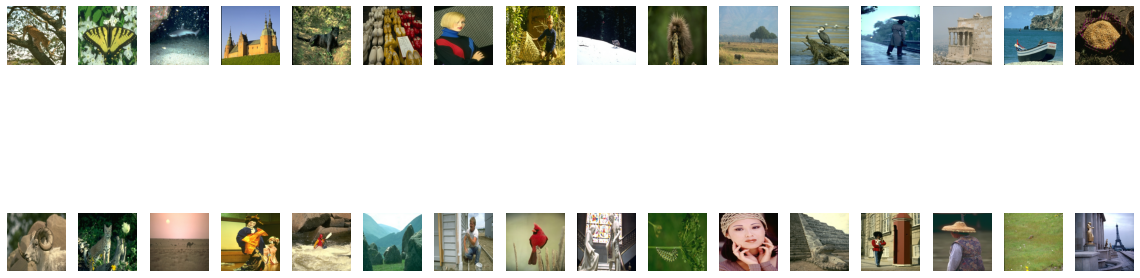

In [9]:
for images in train_ds.take(1):
    display_images(images, rows=2, size=(16, 8))

In [10]:
train_data = (train_ds
              .map(lambda x: (tf.image.resize(x, Config.data.input_shape[:2], method='area'), x))
              .prefetch(buffer_size=Config.data.buffer_size))

valid_data = (valid_ds
              .map(lambda x: (tf.image.resize(x, Config.data.input_shape[:2], method='area'), x))
              .prefetch(buffer_size=Config.data.buffer_size))

images: (32, 100, 100, 3) <dtype: 'float32'>
labels: (32, 300, 300, 3) <dtype: 'float32'>


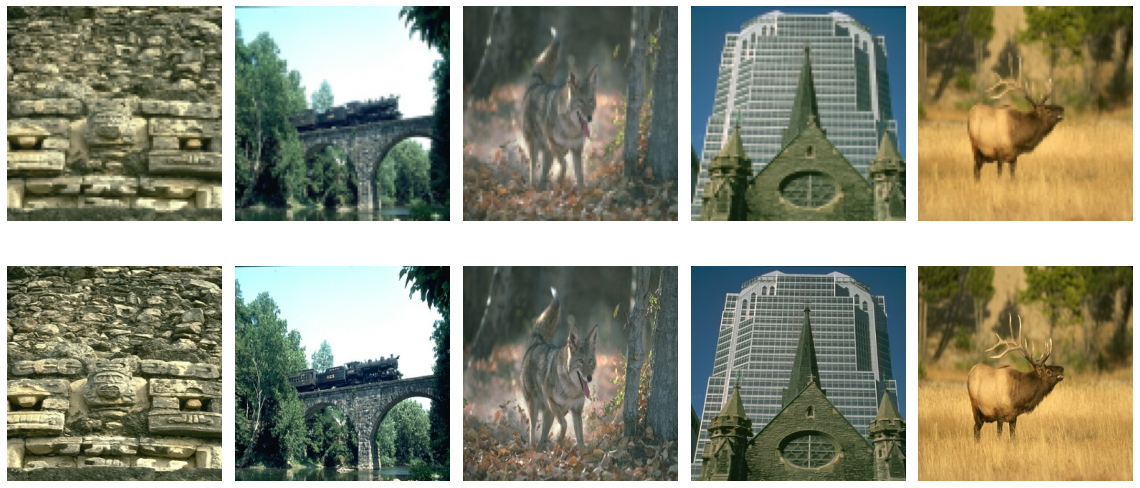

In [11]:
N = 5

for images, labels in train_data.take(1):
    print('images:', images.shape, images.dtype)
    print('labels:', labels.shape, labels.dtype)

    display_images((*images[:N], *labels[:N]),
                   rows=2, size=(16, 8))

## Network

In [12]:
from tensorflow.keras import Model, Sequential, Input
from tensorflow.keras.layers import Lambda, Conv2D, Activation, experimental

shape = Config.data.input_shape
upscale_factor = Config.data.upscale_factor
channels = Config.data.channels

def cv_block(filters=64, kernel_size=3,
             kernel_initializer='Orthogonal',
             padding='same',
             activation='relu',
             name=None):
    return Conv2D(filters, kernel_size, name=name,
                  kernel_initializer=kernel_initializer,
                  padding=padding,
                  activation=activation)

espcnet = Sequential([
    Input(shape=shape, name='images'),
    experimental.preprocessing.Rescaling(1 / 255., name='rescaling'),
    Lambda(lambda x: tf.image.rgb_to_yuv(x), name='rgb_to_yuv'),
    Lambda(lambda x: x[..., :1], name='select_y'),
    cv_block(64, 5, name='cv1'),
    cv_block(64, 3, name='cv2'),
    cv_block(32, 3, name='cv3'),
    cv_block(channels * (upscale_factor ** 2), 3, name='upscale'),
    Lambda(lambda x: tf.nn.depth_to_space(x, upscale_factor), name='depth_to_space')
], name='espcnet')

In [13]:
class ESPCDecoder(tf.keras.layers.Layer):
    def call(self, inputs):
        x, y = inputs

        cb, cr = x[..., 1:2], x[..., 2:3]  # color info.
        y = tf.clip_by_value(y, 0., 1.)    # Valid reconstructed Y values.
        y_size = tf.shape(y)[1:3]

        cb = tf.image.resize(cb, y_size, 'bicubic')
        cr = tf.image.resize(cr, y_size, 'bicubic')

        yuv = tf.concat((y, cb, cr), axis=-1)
        rgb = tf.image.yuv_to_rgb(yuv)

        return rgb


def build_decoder(espc_backbone):
    x, y = (espc_backbone.get_layer('rgb_to_yuv').output,
            espc_backbone.output)
    y = ESPCDecoder(name='yuv_to_rgb')([x, y])
    
    return Model(
        inputs=espc_backbone.inputs,
        outputs=y,
        name='espcnet_decoder')

espcnet_d = build_decoder(espcnet)

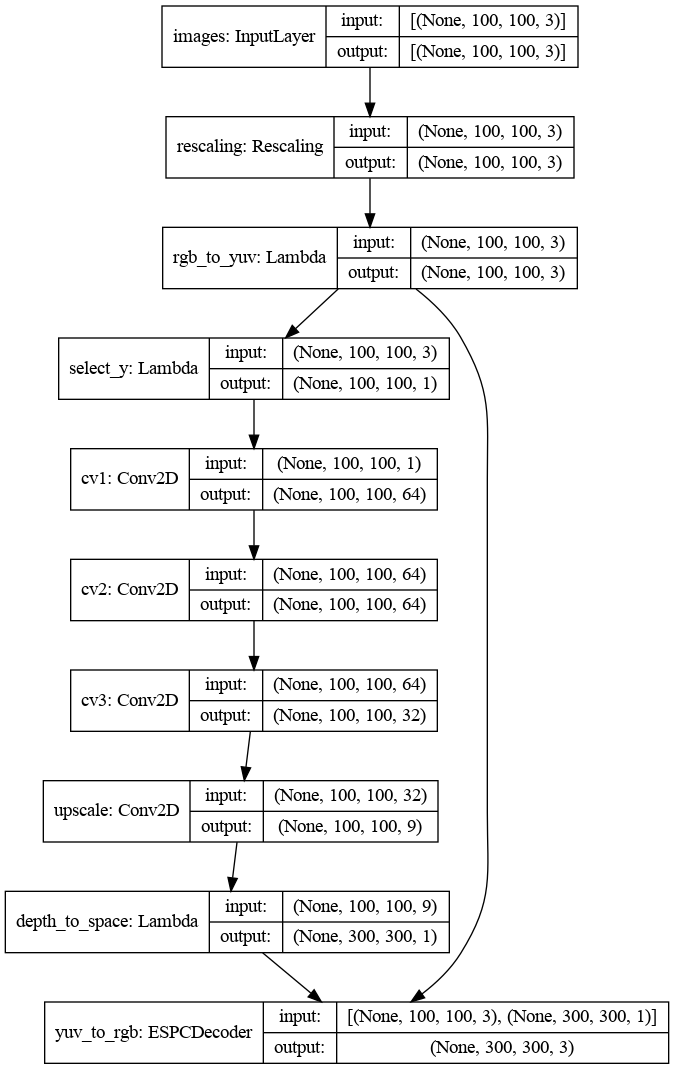

In [14]:
tf.keras.utils.plot_model(espcnet_d, show_shapes=True, expand_nested=True)

## Training

In [15]:
def y_mean_squared_error(y_true, y_pred):
    """Y Coefficient Mean Squared Error.
    
    Convert an input image from RGB (0, 255) to YUV.
    Used as loss function to the model above.
    """
    y = tf.image.rgb_to_yuv(y_true / 255.)[..., :1]  # (B, H, W, 1)
    return tf.losses.mean_squared_error(y, y_pred)

In [16]:
from tensorflow.keras import callbacks

class TensorBoardWithReconstructions(callbacks.TensorBoard):
    def __init__(self, *args, reconstruction_data=None, **kwargs):
        super().__init__(*args, **kwargs)
        self.reconstruction_data = reconstruction_data
    
    def on_epoch_end(self, epoch, logs=None):
        super().on_epoch_end(epoch, logs)
        
        if epoch % self.histogram_freq == 0 and self.reconstruction_data is not None:
            x, y = self.reconstruction_data
            r = espcnet_d.predict(x)
            result = tf.concat(
                (normalize(tf.image.resize(x, y.shape[1:3], 'bicubic')),
                 normalize(y),
                 r),
                axis=2)

            with self._val_writer.as_default():
                tf.summary.image('Reconstruction examples', result, max_outputs=8, step=epoch)

In [17]:
espcnet.compile(optimizer=tf.optimizers.Adam(learning_rate=0.001),
                loss=y_mean_squared_error)

In [18]:
! rm -rf ../../../logs/subpixel/bsds500/

In [19]:
try:
    espcnet.fit(train_data,
                epochs=Config.training.epochs,
                validation_data=valid_data,
                callbacks=[
                    TensorBoardWithReconstructions(
                        Config.training.logs,
                        reconstruction_data=next(iter(valid_data.take(1))),
                        histogram_freq=1),
                    callbacks.ReduceLROnPlateau(
                        factor=.5,
                        patience=Config.training.epochs // 10,
                        verbose=1),
                    callbacks.EarlyStopping(
                        monitor="loss",
                        patience=Config.training.epochs // 2,
                        verbose=1),
                    callbacks.ModelCheckpoint(
                        filepath=Config.training.logs + '/weights.h5',
                        save_weights_only=True,
                        save_best_only=True,
                        verbose=1)
                ])

except KeyboardInterrupt: print('\ninterrupted')
else: print('done')

Epoch 1/100
13/13 [==============================] - 32s 2s/step - loss: 0.1418 - val_loss: 0.0658
Epoch 2/100
13/13 [==============================] - 32s 2s/step - loss: 0.0603 - val_loss: 0.0299
Epoch 3/100
13/13 [==============================] - 31s 2s/step - loss: 0.0191 - val_loss: 0.0093
Epoch 4/100
13/13 [==============================] - 32s 3s/step - loss: 0.0083 - val_loss: 0.0063
Epoch 5/100
13/13 [==============================] - 33s 3s/step - loss: 0.0062 - val_loss: 0.0052
Epoch 6/100
13/13 [==============================] - 33s 3s/step - loss: 0.0049 - val_loss: 0.0044
Epoch 7/100
13/13 [==============================] - 31s 2s/step - loss: 0.0044 - val_loss: 0.0038
Epoch 8/100
13/13 [==============================] - 33s 3s/step - loss: 0.0038 - val_loss: 0.0035
Epoch 9/100
13/13 [==============================] - 31s 2s/step - loss: 0.0034 - val_loss: 0.0033
Epoch 10/100
13/13 [==============================] - 32s 2s/step - loss: 0.0033 - val_loss: 0.0033
Epoch 11/

13/13 [==============================] - 30s 2s/step - loss: 0.0026 - val_loss: 0.0026
Epoch 84/100
13/13 [==============================] - 30s 2s/step - loss: 0.0026 - val_loss: 0.0026
Epoch 85/100
 2/13 [===>..........................] - ETA: 21s - loss: 0.0025
interrupted
